# Example 1: Loading Data
First we import the necessary modules

In [17]:
import torch
from pythermondt.readers import LocalReader
from pythermondt.io import HDF5Parser
from pythermondt.data import units

Next we create a reader object for accessing DataContainers. In PyThermoNDT a reader coordinates 2 components:
1. **Backend:** handles I/O operations (reading from local disk, S3, etc.)
2. **Parser:** converts raw file data into DataContainer objects

The reader class will then orchestrate file discovery, caching, and coordinate backends with different parsers. 
Normally you don't need to worry about this separation - readers automatically:
- Select the appropriate backend (LocalBackend for local files, S3Backend for S3)
- Choose the correct parser based on file extension
- Handle caching and file management

In this example we read HDF5 files from a local folder. The LocalReader will:
- Use LocalBackend to access files on disk
- Auto-select HDF5Parser based on the .hdf5 extension
 
**File Patterns:** Due to differences in configuration, Readers may have different parameters. In case of the LocalReader, you can specify a pattern to match files in the following ways:
- A single file path: `"./data/file.hdf5"`
- A directory path: `"./data"` (reads all supported files in the directory)
- A glob pattern: `"./data/*.hdf5"` (reads all .hdf5 files in the directory)

**Common Glob Patterns:**
- `*.txt` - all .txt files
- `data_*.hdf5` - files starting with "data_"
- `**/*.hdf5` - all .hdf5 files in any subdirectory (when recursive=True)

**Recursive Search:** Add `recursive=True` to include files from all subdirectories. This is supported for directory and glob patterns: 
- `LocalReader("./data", recursive=True)` ==> reads all .hdf5 files in the directory and all of its subdirectories.

In [18]:
# 1. Basic directory reading (auto-detects parser from file extension)
reader_basic = LocalReader("./example_data")

# 2. Explicit parser specification (equivalent to above for .hdf5 files)
reader_explicit = LocalReader(
    pattern="./example_data",
    parser=HDF5Parser
)

# 3. Recursive search in all subdirectories
reader_recursive = LocalReader(
    pattern="./example_data", 
    recursive=True
)

# 4. Glob pattern for only the subfolder files
reader_glob = LocalReader(
    pattern="./example_data/subfolder*/*",
    recursive=True
)

# Compare results
print("=== File Discovery Comparison ===")
print(f"Basic directory: {len(reader_basic.files)} files")
print(f"Explicit parser: {len(reader_explicit.files)} files") 
print(f"Recursive: {len(reader_recursive.files)} files")
print(f"Glob: {len(reader_glob.files)} files")

print("\n=== File Lists ===")
print("Basic directory:")
for file in reader_basic.files: 
    print(f"  {file}")

print("\nReader with explicit parser:")
for file in reader_explicit.files: 
    print(f"  {file}")

print("\nRecursive search:")
for file in reader_recursive.files:
    print(f"  {file}")

print("\nGlob pattern search:")
for file in reader_glob.files:
    print(f"  {file}")


=== File Discovery Comparison ===
Basic directory: 1 files
Explicit parser: 1 files
Recursive: 3 files
Glob: 2 files

=== File Lists ===
Basic directory:
  file:///home/jgrimm/WORKSPACE/pyThermoNDT/examples/example_data/example-data2.hdf5

Reader with explicit parser:
  file:///home/jgrimm/WORKSPACE/pyThermoNDT/examples/example_data/example-data2.hdf5

Recursive search:
  file:///home/jgrimm/WORKSPACE/pyThermoNDT/examples/example_data/example-data2.hdf5
  file:///home/jgrimm/WORKSPACE/pyThermoNDT/examples/example_data/subfolder1/example-data0.hdf5
  file:///home/jgrimm/WORKSPACE/pyThermoNDT/examples/example_data/subfolder2/example-data1.hdf5

Glob pattern search:
  file:///home/jgrimm/WORKSPACE/pyThermoNDT/examples/example_data/subfolder1/example-data0.hdf5
  file:///home/jgrimm/WORKSPACE/pyThermoNDT/examples/example_data/subfolder2/example-data1.hdf5


The reader class provides properties about the files found by the specified source expression and some other useful information.

In [19]:
# Files found by the reader
print(reader_basic.files)

# Other information
print(len(reader_basic)) # number of files that were found
print(reader_basic.remote_source) # whether the reader is remote or local
print(reader_basic.backend) # the backend used to read the files
print(reader_basic.parser) # the parser used to parse the files

['file:///home/jgrimm/WORKSPACE/pyThermoNDT/examples/example_data/example-data2.hdf5']
1
False
None


The Reader object is indexable and iterable
This means, that on each call, the reader only loads one file at a time from the file system and parses it into a DataContainer object, which is then returned
This is very memory efficient, as it allows for lazy loading of data, and only loads data when it is needed

In [20]:
for i, container in enumerate(reader_recursive, 1):
    if i > 2:
        break
    print(f"container: {i} \n" + container.__str__())

container: 1 
/: (root: NodeType.ROOT)
/Data: (Data: NodeType.GROUP)
/Data/Tdata: (Tdata: NodeType.DATASET)
/GroundTruth: (GroundTruth: NodeType.GROUP)
/GroundTruth/DefectMask: (DefectMask: NodeType.DATASET)
/MetaData: (MetaData: NodeType.GROUP)
/MetaData/DomainValues: (DomainValues: NodeType.DATASET)
/MetaData/ExcitationSignal: (ExcitationSignal: NodeType.DATASET)
/MetaData/LookUpTable: (LookUpTable: NodeType.DATASET)

container: 2 
/: (root: NodeType.ROOT)
/Data: (Data: NodeType.GROUP)
/Data/Tdata: (Tdata: NodeType.DATASET)
/GroundTruth: (GroundTruth: NodeType.GROUP)
/GroundTruth/DefectMask: (DefectMask: NodeType.DATASET)
/MetaData: (MetaData: NodeType.GROUP)
/MetaData/DomainValues: (DomainValues: NodeType.DATASET)
/MetaData/ExcitationSignal: (ExcitationSignal: NodeType.DATASET)
/MetaData/LookUpTable: (LookUpTable: NodeType.DATASET)



DataContainer: In-Memory representation of a HDF5-like Structure for Scientific Data
The DataContainer provides a hierarchical data structure similar to HDF5 files, designed for organizing scientific datasets. It organizes data into:

Groups: Logical containers (like folders) that organize related data
Datasets: Actual data arrays stored as PyTorch tensors
Attributes: Metadata stored as key-value pairs on groups or datasets

This structure enables efficient data access, manipulation, and serialization:

In [21]:
# Explore the hierarchical structure
container = reader_recursive[0]
print("DataContainer structure:")
print(f"Groups: {container.get_all_groups()}")
print(f"Datasets: {container.get_all_dataset_names()}")
print(f"Memory usage: {container.memory_bytes() / 1024**2:.1f} MB")

# Access and manipulate data
print(f"\nData shape: {container.get_dataset('/Data/Tdata').shape}")
print(f"Original LUT range: {container.get_dataset('/MetaData/LookUpTable').min():.1f} - {container.get_dataset('/MetaData/LookUpTable').max():.1f}")

# Modify data in-place
container.update_dataset("/MetaData/LookUpTable", torch.linspace(0, 500, 256))
print(f"Updated LUT range: {container.get_dataset('/MetaData/LookUpTable').min():.1f} - {container.get_dataset('/MetaData/LookUpTable').max():.1f}")

# Add metadata attributes
container.add_attribute("/Data/Tdata", "calibration_applied", True)
print(f"Added attribute: {container.get_attribute('/Data/Tdata', 'calibration_applied')}")

# Serialize the container to hdf5 file with compression
from io import SEEK_END
serialize_bytes = container.serialize_to_hdf5(compression="lzf")
serialize_bytes.seek(0, SEEK_END)
print("\nSerialized data to HDF5 format with compression:")
print("Type of serialized data:", type(serialize_bytes))
print("Size of serialized data:", serialize_bytes.tell(), "bytes")

# Memory usage breakdown
print("\nMemory breakdown:")
container.print_memory_usage()

DataContainer structure:
Groups: ['Data', 'GroundTruth', 'MetaData']
Datasets: ['Tdata', 'DefectMask', 'DomainValues', 'ExcitationSignal', 'LookUpTable']
Memory usage: 19.6 MB

Data shape: torch.Size([100, 100, 1000])
Original LUT range: 293.1 - 321.3
Updated LUT range: 0.0 - 500.0
Added attribute: True

Serialized data to HDF5 format with compression:
Type of serialized data: <class '_io.BytesIO'>
Size of serialized data: 5837297 bytes

Memory breakdown:
DataContainer Memory Usage: 19.11 MB
------------------------------------
/Data/Tdata                      19.07 MB ( 99.8%) [dataset]
/GroundTruth/DefectMask          10.68 KB (  0.1%) [dataset]
/MetaData/ExcitationSignal        8.50 KB (  0.0%) [dataset]
/MetaData/DomainValues            8.48 KB (  0.0%) [dataset]
/MetaData                         4.95 KB (  0.0%) [group]
/MetaData/LookUpTable             1.67 KB (  0.0%) [dataset]
/GroundTruth                     212.00 B (  0.0%) [group]
/Data                            205.00 B (

Each dataset in the datacontainer also has a unit attribute, which is a dict that describes the physical unit of the data. All the available units are defined in `pythermondt.data.units`: 

In [22]:
# Available units
units.print_available_units()

Unit(name='arbitrary', quantity='arbitrary', symbol='a. u.')
Unit(name='celsius', quantity='temperature', symbol='°C')
Unit(name='dimensionless', quantity='dimensionless', symbol='1')
Unit(name='hertz', quantity='frequency', symbol='Hz')
Unit(name='kelvin', quantity='temperature', symbol='K')
Unit(name='millisecond', quantity='time', symbol='ms')
Unit(name='second', quantity='time', symbol='s')
Unit(name='undefined', quantity='undefined', symbol='N/A')


The unit dict can be accessed via the get_unit method of the datacontainer.

In [23]:
# Accessing units
print("\n Accessing units:")
print(container.get_unit("/MetaData/LookUpTable"))
print(container.get_unit("/Data/Tdata"))


 Accessing units:
Unit(name='kelvin', quantity='temperature', symbol='K')
Unit(name='arbitrary', quantity='arbitrary', symbol='a. u.')


The DataContainer object also provides methods to view frames or the pixel profile of the Temperature data. These functions automatically generate the correct labels based on the unit of the data. In case of the pixel profile, the Temperature data is labeled as arbitrary, because the data itself inside the datacontainer is stored in UINT16 format. To get the correct temperature values, the data has to be converted using the LookUpTable in the datacontainer. See [example 3](./example3_transforming_data.ipynb) for more information on how to do this.

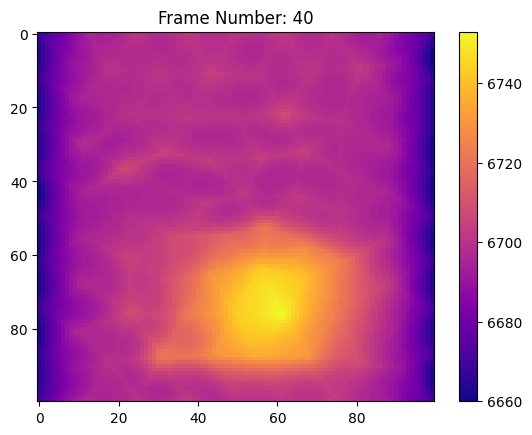

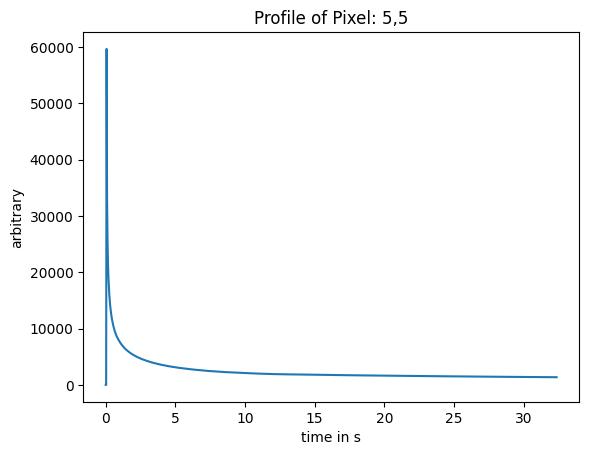

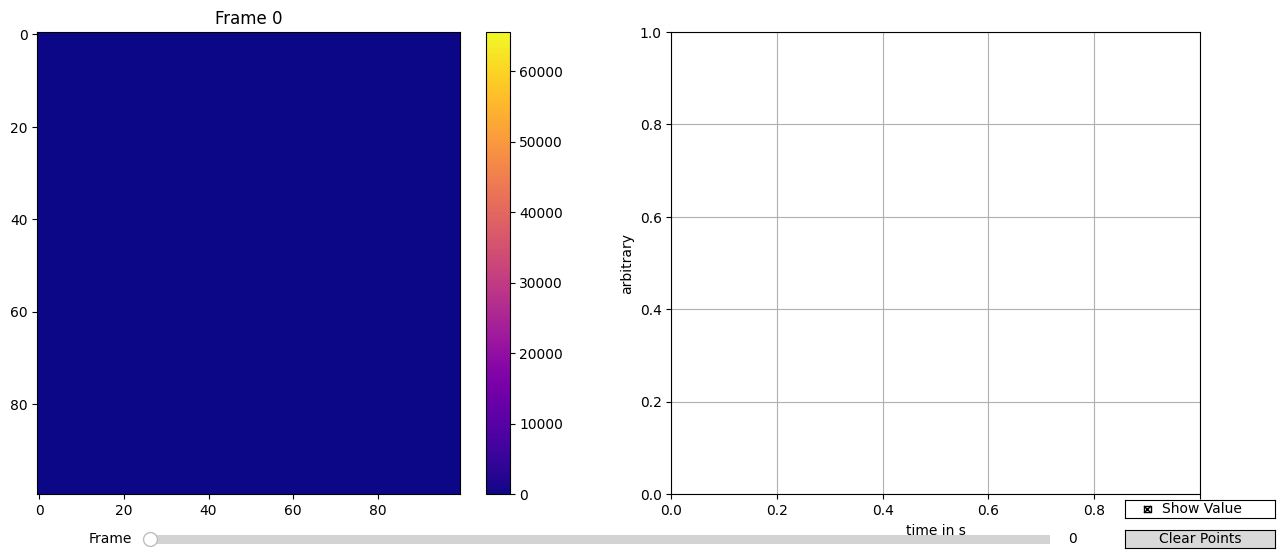

In [24]:
container = reader_basic[0]

container.show_frame(40)
container.show_pixel_profile(5, 5)  
container.analyse_interactive() # Note: Interactive control does not work in JupyterNotebooks ==> use in a script